# Matrix Factorization Problems

In [1]:
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis, NMF
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 8, 6

In [2]:
def frobenius_norm(a):
    return np.sqrt((a ** 2).sum())


def plot_quiver(axes, U, V, width=0.003, headwidth=10, headlength=10,
                **kwargs):
    axes.quiver([0], [0], U, V, angles='xy', scale_units='xy', scale=1,
                width=width, headwidth=headwidth, headlength=headlength,
                **kwargs)

In [3]:
m = 5
np.random.seed(7)

X = np.random.normal(size=(m, 2))

### 1. PCA

#### Decomposition

We want to obtain the eigenvectors of the covariance matrix $\Sigma := XX^T$. One way is to perform the **_eigendecomposition_** (aka **_spectral decomposition_** or **_diagonalization_**)

$$\Sigma = Q \Lambda Q^T$$

where the columns of $Q$ are eigenvectors of $\Sigma$.

However, in practice, more often the **_singular value decomposition_**

$$\Sigma = USV^T$$

is used instead. This is because when applied to a symmetric positive semi-definite matrix (which $\Sigma$ is), the eigendecomposition and the SVD coincide (up to order of eigenvalues and signs of eigenvectors).

Moreover, given an SVD of $\Sigma$, we have

$$\Sigma\Sigma^T = USV^TVS^TU^T = U(SS^T)U^T = U\hat{S}^2U^T$$

meaning that the columns of $U$ (the left-singular vectors of $\Sigma$ in the SVD) are also eigenvectors of $\Sigma\Sigma^T$. Thus the columns of $U$ are eigenvectors of both $\Sigma$ and $\Sigma\Sigma^T$.

In [4]:
# Compute covariance matrix of X
m = X.shape[0]
X_norm = X - X.mean(axis=0)
Sigma = 1/m * X_norm.T @ X_norm

# SVD
U, s, VT = np.linalg.svd(Sigma)
S = np.diag(s)

# Verify equality of decomposition
print('Frobenius norm of SVD :', frobenius_norm(Sigma - U@S@VT))

# Eigendecomposition
l, Q = np.linalg.eig(Sigma)
Lambda = np.diag(l)

print('\nEigenvectors of Sigma returned by SVD =\n', U, sep='')
print('\nEigenvectors of Sigma returned by eigendecomposition =\n',
      Q, sep='')
print('\nEigenvectors of Sigma Sigma.T =\n',
      np.linalg.eig(Sigma @ Sigma.T)[1], sep='')

Frobenius norm of SVD : 2.2971826326221923e-16

Eigenvectors of Sigma returned by SVD =
[[-0.81947463 -0.57311546]
 [-0.57311546  0.81947463]]

Eigenvectors of Sigma returned by eigendecomposition =
[[ 0.81947463 -0.57311546]
 [ 0.57311546  0.81947463]]

Eigenvectors of Sigma Sigma.T =
[[ 0.81947463 -0.57311546]
 [ 0.57311546  0.81947463]]


#### Transformation

The principal components of $X$ are given by the eigenvectors of $\Sigma$, that is, the columns of $U$. To transform $X$, we project it onto the $k$-dimensional linear subspace spanned by the $k$ eigenvectors:

$$z^{(i)} := U_{reduce}^T x^{(i)}$$
or
$$Z := XU_{reduce}$$

In [5]:
# Manually perform projection
first_comp = np.c_[U[:, 0]]
Z = X @ first_comp

# Results of PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

print('First component =\n', first_comp, sep='')
print('\nPrincipal component returned by PCA =\n',
      pca.components_.reshape(-1, 1), sep='')

print('\nProjections =\n', Z, sep='')
print('\nTransformed X returned by PCA =\n', X_pca, sep='')

print('\nFrobenius norm =', frobenius_norm(Z - X_pca))

First component =
[[-0.81947463]
 [-0.57311546]]

Principal component returned by PCA =
[[-0.81947463]
 [-0.57311546]]

Projections =
[[-1.11830702]
 [-0.26044917]
 [ 0.6453186 ]
 [ 1.00638927]
 [-1.1780999 ]]

Transformed X returned by PCA =
[[-0.93727737]
 [-0.07941953]
 [ 0.82634824]
 [ 1.18741892]
 [-0.99707026]]

Frobenius norm = 0.4047945901263485


#### Reconstruction of samples

If all principal components were kept, $X$ can be perfectly reconstructed because

$$ZU^T = XUU^T = X$$

However, when $k < n$, the best possible reconstruction is

$$X_{approx} := ZU_{reduce}^{T} = XU_{reduce}U_{reduce}^T \neq X$$

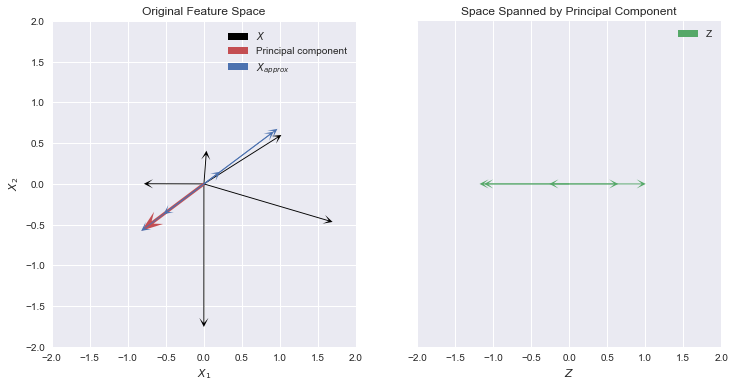

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original data
plot_quiver(axes[0], X[:, 0], X[:, 1], label='$X$')

# Principal component
plot_quiver(axes[0], first_comp[0], first_comp[1],
            width=0.01, headwidth=5, headlength=7, color='C2',
            label='Principal component')

# Reconstructed data
X_approx = Z @ first_comp.T
plot_quiver(axes[0], X_approx[:, 0], X_approx[:, 1], color='C0',
            label='$X_{approx}$')

axes[0].axis([-2, 2, -2, 2])
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('Original Feature Space')
axes[0].legend()

# Projection
plot_quiver(axes[1], Z, [0]*m, color='C1', label='Z')

axes[1].axis([-2, 2, -2, 2])
axes[1].set_xlabel('$Z$')
axes[1].get_yaxis().set_visible(False)
axes[1].set_title('Space Spanned by Principal Component')
axes[1].legend()

plt.show()

### 2. Truncated SVD (LSA)

#### Decomposition

Let $Y:= X^T$. The algorithm first computes an orthonormal matrix $Q$ of shape `(n_features, n_components + n_oversamples)` whose range approximates the range of $Y$, projects $Y$ onto a lower-dimensional space to obtain a low-rank approximation $Y_k$:

$$Y_k := Q^TY$$

(or equivalently, $Y_k^T := Y^TQ = XQ$)

and then perform the SVD on the approximation:

$$Y_k = \hat{U_k}S_kV_k^T$$
$$U_k = Q\hat{U_k}$$

where the transposed columns of $U_k$ are the components.

In [7]:
# Results of TruncatedSVD
tsvd = TruncatedSVD(n_components=1)
X_tsvd = tsvd.fit_transform(X)

# Compare with SVD
U, s, VT = np.linalg.svd(X)
svd_component = VT[0, :].reshape(1, -1)

print('TruncatedSVD component =\n', tsvd.components_, sep='')
print('\nSVD component =\n', svd_component, sep='')

TruncatedSVD component =
[[ 0.97593037 -0.21808235]]

SVD component =
[[-0.97593037  0.21808235]]


#### Transformation

$$Z = U_kS_k^T$$

is the transformed training set, and new data are transformed by multiplying with $V_k$:

$$X_{new}' = X_{new}V_k$$

In [8]:
print('Transformed X, with TruncatedSVD =\n', X_tsvd, sep='')
print('\nTransformed X, with SVD =\n', np.c_[U[:, 0]] * s[0], sep='')

np.random.seed(3)
X_test = np.random.normal(size=(5, 2))

print('\nTransformed new data, with TruncatedSVD =\n', tsvd.transform(X_test),
      sep='')
print('\nTransformed new data, with SVD =\n', (X_test @ svd_component.T),
      sep='')

Transformed X, with TruncatedSVD =
[[ 1.75144809]
 [-0.05684192]
 [-0.77038441]
 [ 0.38180545]
 [ 0.86220522]]

Transformed X, with SVD =
[[-1.75144809]
 [ 0.05684192]
 [ 0.77038441]
 [-0.38180545]
 [-0.86220522]]

Transformed new data, with TruncatedSVD =
[[ 1.65038175]
 [ 0.50056968]
 [-0.1933449 ]
 [ 0.05598786]
 [ 0.06130935]]

Transformed new data, with SVD =
[[-1.65038175]
 [-0.50056968]
 [ 0.1933449 ]
 [-0.05598786]
 [-0.06130935]]


### 3. Factor analysis

The factor analysis model is explaining the observed covariance structure of the data by:

1. representing the independent noise variances for each variable into the diagonal elements of $\Psi$; and
2. capturing the covariance between variables in the columns of $W$ (called *factor loadings*) (Bishop, 12.2.4).

#### Decomposition

$$X = WH + M + E$$

#### Transformation

$$z = GW^T\Psi^{-1}(x - \bar{x})$$
or in vectorized form
$$Z = X_{normalized}\Psi^{-1}WG$$
where
$$G = (I + W^T\Psi^{-1}W)^{-1}$$

In [9]:
# Results of FactorAnalysis
fa = FactorAnalysis(n_components=1)
X_fa = fa.fit_transform(X)
WT = fa.components_
W = WT.T
Psi = fa.noise_variance_

# Manual calculation
G = np.linalg.inv(np.eye(1) + WT/Psi@W)

print('Transformed X =\n', (X-X.mean(axis=0)) / Psi @ W @ G, sep='')
print('\nTransformed X returned by FactorAnalysis =\n', X_fa, sep='')

Transformed X =
[[-0.28701875]
 [-0.08391787]
 [ 0.24887319]
 [ 0.52372514]
 [-0.40166171]]

Transformed X returned by FactorAnalysis =
[[-0.28701875]
 [-0.08391787]
 [ 0.24887319]
 [ 0.52372514]
 [-0.40166171]]


### 4. NMF

$X$ is decomposed into $W$ and $H$ of non-negative elements:

$$X \approx WH$$

$W$ is the transformed data, and reconstructed samples $X' = WH$.

In [10]:
np.random.seed(7)
X = np.random.randint(10, size=(m, 2))

nmf = NMF(n_components=1)
X_nmf = nmf.fit_transform(X)

# Verify equality of decomposition (also reconstruction)
print('Frobenius norm of SVD :', frobenius_norm(X - X_nmf@nmf.components_))

Frobenius norm of SVD : 4.204859089024913
